In [146]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import plotting
import importlib
importlib.reload(plotting)

<module 'plotting' from '/home/frankwoods/Desktop/lassie/plotting.py'>

# Load in all depth vs resistance curves into a dataframe list

In [147]:
def load_data(data_src):
    depth_resist_curve_df_list = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        depth_resist_curve_df_list.append(df)
        filename_list.append(filename)
    return depth_resist_curve_df_list, filename_list

data_src = "data/cleaned_data"
depth_resist_curve_df_list, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, depth_resist_curve_df_list))

In [148]:
data_features_df = pd.read_csv("data/features.csv")
non_clustering_features_list = ['filenames', 'feifeis_ylabels', 'liams_ylabels', 'marions_ylabels', 'distances']
clustering_features_df = data_features_df.drop(non_clustering_features_list, axis=1)

# K-Means Clustering Implementation w/ k-means++ initialization for centroids

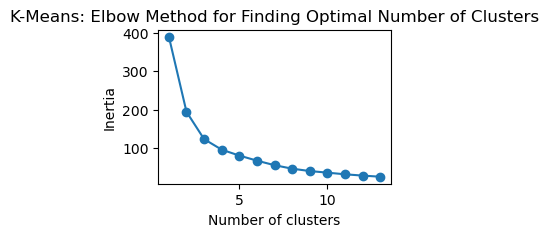

In [149]:
inertias = []
for k in range(1,14):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=100).fit(clustering_features_df)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(3,2))
plt.plot(range(1,14), inertias, marker='o')
plt.title("K-Means: Elbow Method for Finding Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid=True
plt.show()

# K-Means Clustering
- assumes
    - spherical clusters (isotropic)
    - similar size clusters (equal variance)
    - features are on same scale
    - clusters are linearly separable
    - number of clusters (k) is known

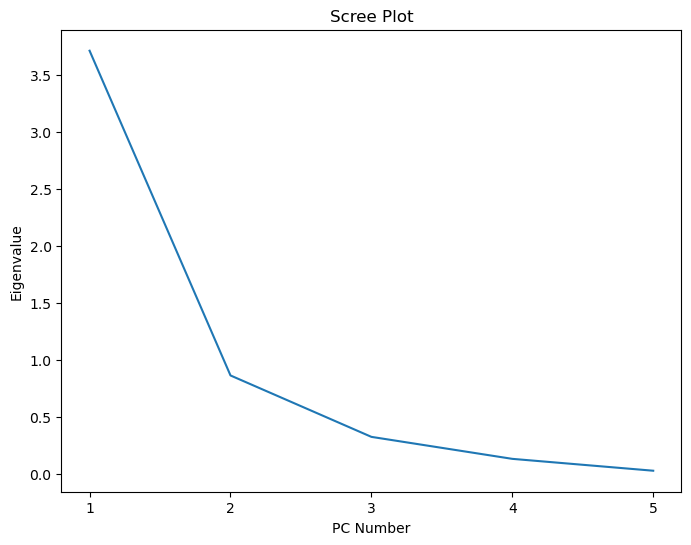

    Eigenvalue  Proportion  Cumulative
PC                                    
1     3.710286    0.732544    0.732544
2     0.864627    0.170708    0.903252
3     0.326453    0.064453    0.967706
4     0.133789    0.026415    0.994120
5     0.029780    0.005880    1.000000


                         PC1       PC2       PC3       PC4       PC5
overall_slope       0.506782  0.103371  0.308902 -0.083119  0.793824
max_depth          -0.498963 -0.040149 -0.259672  0.661708  0.494102
max_resistance      0.487453  0.208520  0.233649  0.734980 -0.352309
num_peaks          -0.448096 -0.119916  0.884486  0.031225 -0.039229
largest_force_drop -0.236234  0.964283  0.015541 -0.118591  0.006780


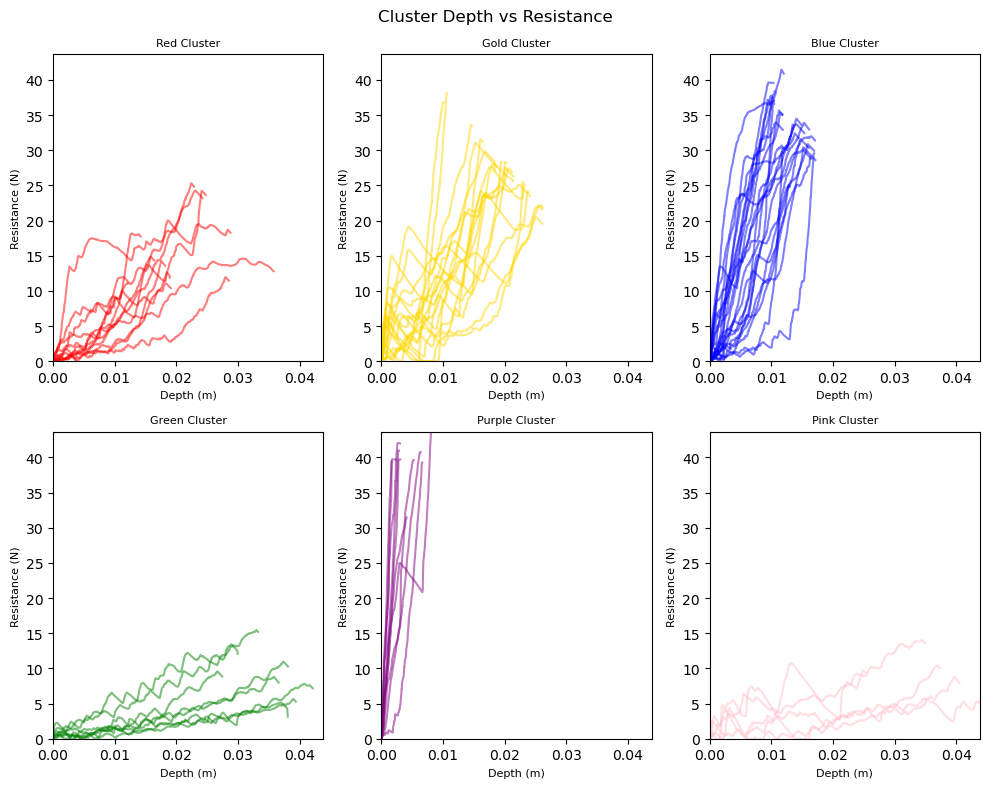

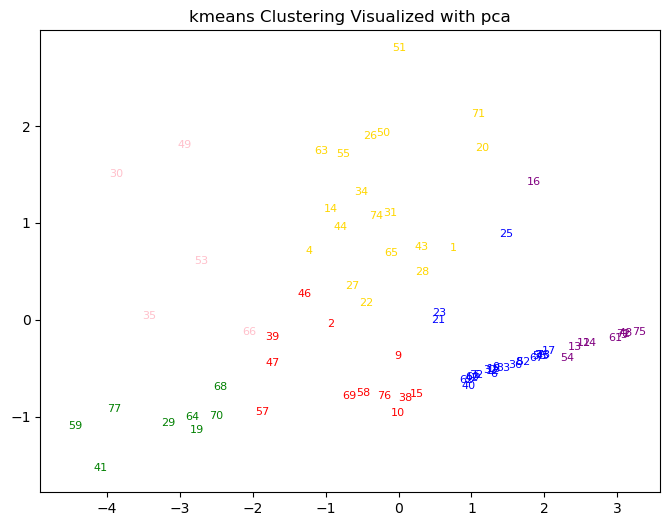

In [150]:
kmeans_elbow = 6
kmeans = KMeans(n_clusters=kmeans_elbow, init="k-means++", n_init=100).fit(clustering_features_df)
# print(f"kmeans cluster centers: {kmeans.cluster_centers_}")
plotting.pca_analysis(clustering_features_df) # printing scree plot
# plotting.plot_clusters_together(kmeans.labels_, "kmeans")
plotting.plot_clusters_seperately(kmeans.labels_, clustering_features_df.index.tolist(), depth_resist_curve_df_list, data_features_df, "kmeans")
plotting.plot_pca(clustering_features_df, y_labels=kmeans.labels_, num_pc=2, graph_title="kmeans")

# Hierarchical Clustering

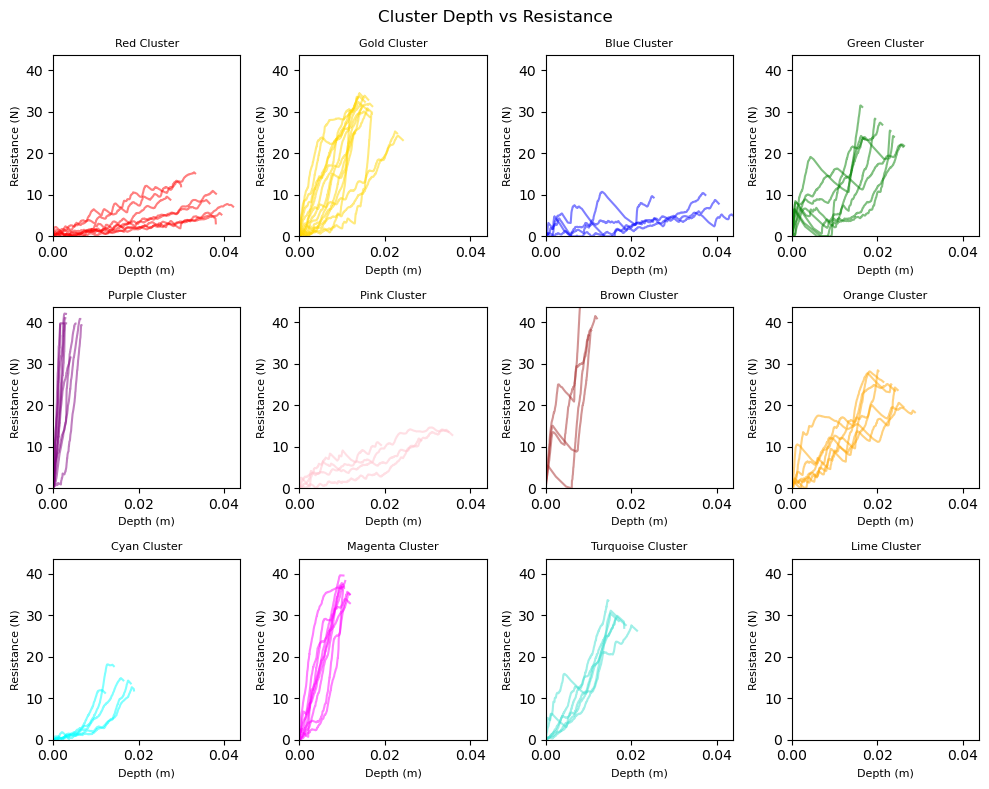

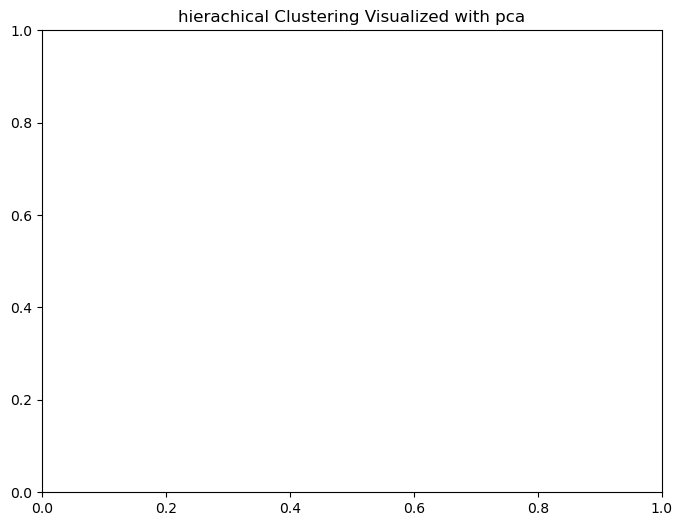

In [151]:

# if distance_threshold != None then n_clusters = None
hierarchical = AgglomerativeClustering(distance_threshold=None, n_clusters=11)
hierarchical.fit(clustering_features_df)
linkage = "Ward"
plotting.plot_clusters_seperately(hierarchical.labels_, clustering_features_df.index.tolist(), depth_resist_curve_df_list, data_features_df, 'hierarchical')
plotting.plot_pca(clustering_features_df, y_labels=hierarchical.labels_, num_pc=3, graph_title="hierachical")

# DBSCAN

In [152]:

# eps=0.7, min_samples=3 works very well
# dbscan = DBSCAN(eps=1.8, min_samples=10).fit(clustering_features_df)
# cleaned_db_labels = [label if label != -1 else max(dbscan.labels_)+1 for label in dbscan.labels_]
# # get_curve_idx_from_cluster_color("yellow", cleaned_db_labels)
# plotting.plot_pca(clustering_features_df, cleaned_db_labels, 'dbscan')
# plotting.plot_clusters_seperately(cleaned_db_labels, clustering_features_df.index.to_list(), depth_resist_curve_df_list)